In [1]:
# Install requirements
!pip install image-classifiers==1.0.0

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
SEED = 123
N_CLASSES = 6
BATCH_SIZE = 32
IMAGE_SIZE=(256,256)
LR = 1e-3
EPOCHS = 10
ACTIVATION = 'sigmoid' if N_CLASSES == 2 else 'softmax'
BACKBONE = 'resnet18'

## Model

In [4]:
from classification_models.tfkeras import Classifiers

In [5]:
# get base architecture and correct preprocessing function
arch, preprocess_input = Classifiers.get(BACKBONE)

# determine the base model
input_shape = IMAGE_SIZE+(3,)
base_model = arch(input_shape,
                  weights='imagenet',
                  include_top=False
                 )
# freeze the layers in base_model
for layer in base_model.layers:
    layer.trainable = False
    
# classification head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(N_CLASSES, activation=ACTIVATION)(x)

# wrap into a model
model = tf.keras.models.Model(inputs=[base_model.input],
                              outputs=[output],
                              name=f'{BACKBONE}-classifier'
                             )

In [6]:
optimizer = tf.keras.optimizers.Adam(LR)
loss = 'binary_crossentropy' if N_CLASSES==1 else 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer, loss, metrics)

In [7]:
#model.summary()

## Data

In [8]:
DATA_DIR = './data/Monkeys Faces/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('wget "https://www.dropbox.com/s/35ithckx6vqryob/Monkeys_Faces_Dataset.tar?dl=0" -O ./data/Monkeys_Faces_Dataset.tar')
    os.system('cd ./data && tar --warning=no-unknown-keyword --exclude=".*" -xzf ./Monkeys_Faces_Dataset.tar')
    print('Done!')

In [9]:
try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *

In [10]:
# augmentations
AUGMENTATIONS = albumentations.Compose([
    # flips
    albumentations.HorizontalFlip(p=0.25),
    albumentations.VerticalFlip(p=0.25),
    # color augmentations
    albumentations.OneOf([
        albumentations.HueSaturationValue(p=1.),
        albumentations.RandomBrightnessContrast(p=1.),
        albumentations.RGBShift(p=1.)
    ], p=0.25),
    # image quality
    albumentations.OneOf([
        albumentations.GaussNoise(p=1.),
        albumentations.MultiplicativeNoise(p=1.),
        albumentations.JpegCompression(p=1.),
        albumentations.Downscale(scale_min=0.5,scale_max=0.99, p=1),
    ], p=0.5),
    # other
    albumentations.OneOf([
        albumentations.ToGray(p=1.),
        albumentations.RandomResizedCrop(height=IMAGE_SIZE[0], 
                                         width=IMAGE_SIZE[1], 
                                         p=1.),
        
    ], p=0.25),
])

In [11]:
# dataloaders
dg = ImageDataAugmentor(augment=AUGMENTATIONS, 
                        seed=SEED,
                        validation_split=0.25
                       )

training_generator = dg.flow_from_directory(DATA_DIR, 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            subset='training'
                                           )
validation_generator = dg.flow_from_directory(DATA_DIR, 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=IMAGE_SIZE,
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 254 images belonging to 6 classes.
Found 81 images belonging to 6 classes.


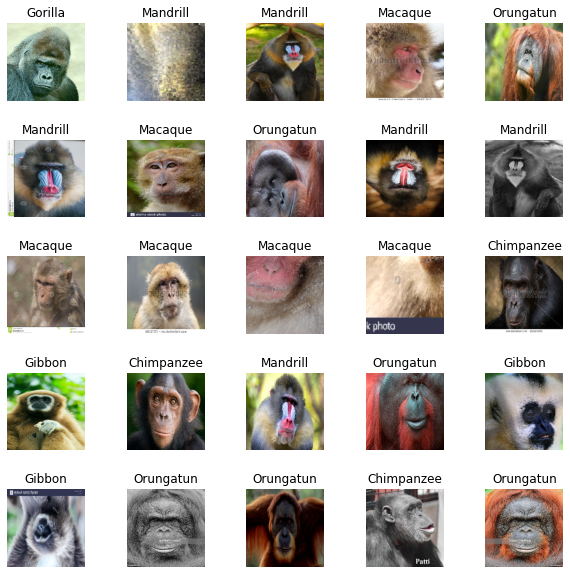

In [12]:
# visualize some augmented data
training_generator.show_data()

## Training

In [13]:
def plot_training_statistics(history,):
    epochs = [i for i in range(1, len(history['loss'])+1)]

    plt.figure(figsize=(16,6))
    keys = history.keys()
    keys = [key for key in keys if not "lr" in key and not "val_" in key]
    
    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx+1)
        plt.plot(epochs, history[key], label="training_"+key)
        plt.plot(epochs, history['val_'+key], label="validation_"+key)
        plt.legend(loc='best')
        plt.title(key)
        plt.xlabel('epoch')
        
    plt.show()
    plt.close('all')

Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 2.2031 - accuracy: 0.1525 - val_loss: 1.7897 - val_accuracy: 0.2593
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 1.7619 - accuracy: 0.3131 - val_loss: 1.4744 - val_accuracy: 0.4568
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 1.3979 - accuracy: 0.5047 - val_loss: 1.2407 - val_accuracy: 0.5802
Epoch 4/10
8/8 [==============================] - 13s 2s/step - loss: 1.1862 - accuracy: 0.6173 - val_loss: 0.9880 - val_accuracy: 0.6914
Epoch 5/10
8/8 [==============================] - 13s 2s/step - loss: 0.9802 - accuracy: 0.7072 - val_loss: 0.9082 - val_accuracy: 0.7654
Epoch 6/10
8/8 [==============================] - 12s 2s/step - loss: 0.8163 - accuracy: 0.7764 - val_loss: 0.7990 - val_accuracy: 0.8148
Epoch 7/10
8/8 [==============================] - 13s 2s/step - loss: 0.6925 - accuracy: 0.8291 - val_loss: 0.6779 - val_accuracy: 0.8519
Epoch 8/10
8/8 [==================

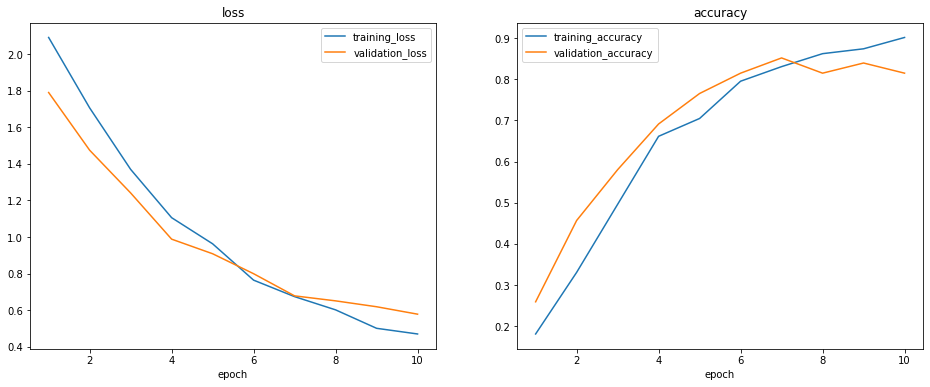

In [14]:
# train model: this will only train the decoder of the Unet
history = model.fit(
    training_generator, 
    steps_per_epoch=len(training_generator), 
    epochs=EPOCHS, 
    validation_data=validation_generator, 
    validation_steps=len(validation_generator),
)
plot_training_statistics(history.history)

In [15]:
# # uncomment this to continue finetuning all layers of the model
# for layer in model.layers:
#     layer.trainable = True
# ft_history = model.fit(
#     training_generator, 
#     steps_per_epoch=len(training_generator)*5, 
#     epochs=EPOCHS, 
#     callbacks=callbacks, 
#     validation_data=validation_generator, 
#     validation_steps=len(validation_generator)*5,
# )

## Inference

In [16]:
import numpy as np
import urllib.request
import cv2

def url_to_image(url:str):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

def preprocess_image(image:np.array, ):
    tgt_h,tgt_w = IMAGE_SIZE
    image = cv2.resize(image, (tgt_w, tgt_h))
    image = preprocess_input(image)
    image = image[None,...]
    image = np.float32(image)
    return image

class_mapper = {v: k for k, v in training_generator.class_indices.items()}

In [17]:
img_link = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Male_gorilla_in_SF_zoo.jpg/440px-Male_gorilla_in_SF_zoo.jpg"

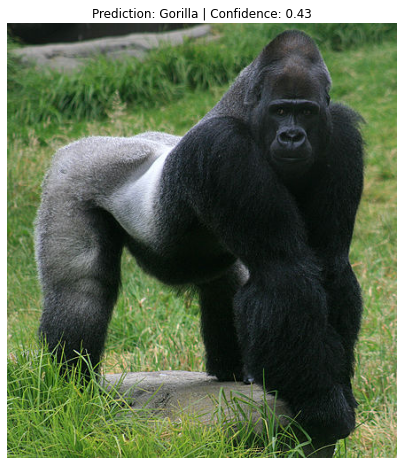

In [18]:
# get image
img = url_to_image(img_link)
img = img[..., ::-1] #from BGR to RGB

# predict
pred = model.predict(preprocess_image(img))
pred_class = class_mapper[pred.argmax()]
pred_confidence = pred.max()

# visualize
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title(f"Prediction: {pred_class} | Confidence: {pred_confidence:.2f}")
plt.axis('off')
plt.show()